In [20]:
using Images
using TestImages
using FileIO
using Colors
using ImageFeatures
using Formatting
using Plots
using DSP

In [21]:
function backwardTransform(algo, M, P, outSize=nothing)
  M = inv(M)
  rows, cols = size(P)
  if outSize == nothing
    outSize = size(P)
  end
  out = zeros(eltype(P), outSize)

  for index in CartesianIndices(out)
    y, x = Tuple(index)
    sourceIndex = M * [x; y; 1]
    sourceIndex ./= sourceIndex[end]
    x1, y1 = round.(Int32, sourceIndex)
    if (x1 < 1 || y1 < 1 || x1 > cols || y1 > rows)
      continue
    end
    out[index] = P[y1, x1]
  end
  out
end

backwardTransform (generic function with 2 methods)

In [22]:
function createProjectiveMatrix(points)
  if length(points) != 4
    error("Not correct number of point")
  end

  A = zeros(Int64, 2*length(points), 8)
  B = zeros(Int64, 2*length(points), 1)
  for i in 1:length(points)
    x, y, x1, y1 = points[i]
    A[2*i - 1,:] = [x y 1 0 0 0 -x*x1 -x1*y]
    A[2*i,:] = [0 0 0 x y 1 -x*y1 -y*y1]
    B[2*i - 1] = x1
    B[2*i] = y1
  end

  H = vcat(A\B, 1)
  reshape(H, (3,3))'
end

function projectiveTransform(picture, points, outSize)
  M = createProjectiveMatrix(points)
  backwardTransform("zero", M, picture, outSize)
end

projectiveTransform (generic function with 1 method)

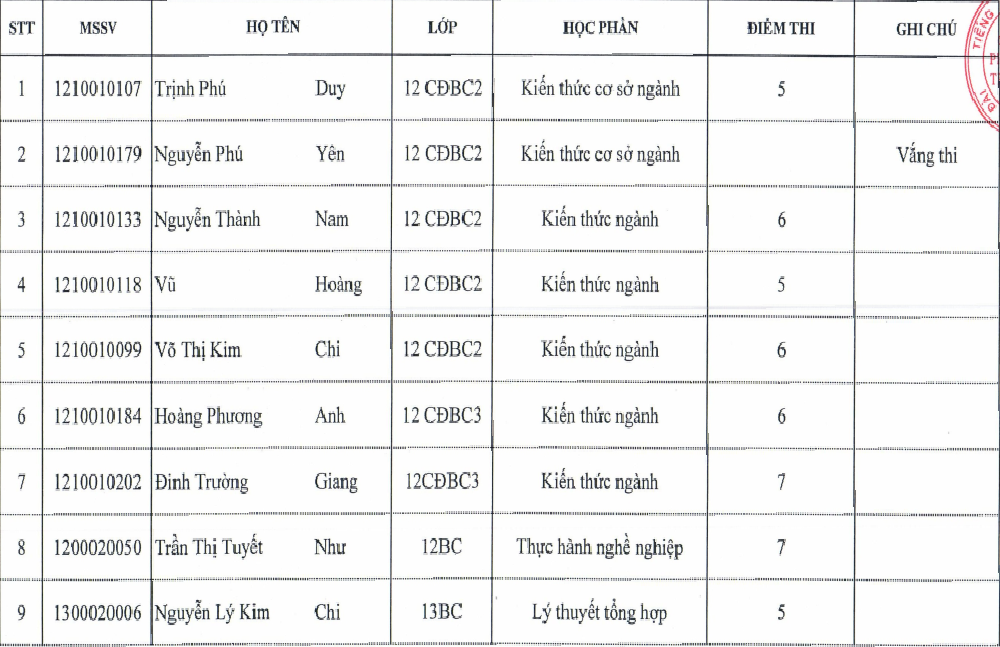

In [25]:
source = load("../images/bangdiem.png")
row, col = size(source)
points = [
  # [x y x1 y1],
  [14 152 1 1],
  [969 155 col 1],
  [965 637 col row],
  [14 633 1 row]
]

scanned = projectiveTransform(source, points, size(source))

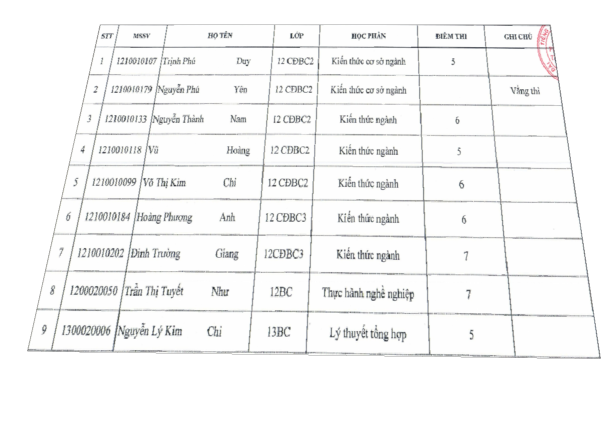

In [88]:
row, col = size(scanned)
points = [
  # [x y x1 y1],
  [1 1 200 50],
  [col 1 (col+100) 50],
  [col row (col+200) (row+70)],
  [1 row 55 (row+55)]
]

raw = projectiveTransform(scanned, points, size(source) .+ 200)

In [89]:
function create_cdf(arr)
    hist = zeros(256)
    for val in arr
      val = round(Int32, val)
       hist[val + 1] += 1
    end
    cdf = cumsum(hist)
    cdf ./= length(arr)
    cdf, hist
end

function histogramMatching(origin_img, prefered_img)
  origin_img_ycbcr = channelview(YCbCr.(origin_img))
  prefered_img_ycbcr = channelview(YCbCr.(prefered_img))

  out_img = similar(origin_img)
  out_img_ycbcr = channelview(YCbCr.(out_img))

  for c in 1:3
    origin_channel = origin_img_ycbcr[c,:,:]
    prefered_channel = prefered_img_ycbcr[c,:,:]
    
    origin_cdf, origin_hist = create_cdf(origin_channel)
    prefered_cdf, prefered_hist = create_cdf(prefered_channel)

    mapping = zeros(256)
    for i in 1:256
        idx = argmin(abs.(prefered_cdf .- origin_cdf[i]))
        mapping[i] = idx - 1
    end

    display(mapping)

    out_img = out_img_ycbcr[c,:,:]
    for idx in CartesianIndices(out_img)
        old_color = round(Int32,origin_channel[idx])
        new_color = mapping[old_color]
        out_img[idx] = new_color
    end
  end
  out_img
end

histogramMatching (generic function with 1 method)

256-element Array{Float64,1}:
   0.0
   0.0
   0.0
   0.0
   0.0
   0.0
   0.0
   0.0
   0.0
   0.0
   0.0
   0.0
   0.0
   ⋮  
 235.0
 235.0
 235.0
 235.0
 235.0
 235.0
 235.0
 235.0
 235.0
 235.0
 235.0
 235.0

256-element Array{Float64,1}:
   0.0
   0.0
   0.0
   0.0
   0.0
   0.0
   0.0
   0.0
   0.0
   0.0
   0.0
   0.0
   0.0
   ⋮  
 128.0
 128.0
 128.0
 128.0
 128.0
 128.0
 128.0
 128.0
 128.0
 128.0
 128.0
 128.0

256-element Array{Float64,1}:
   0.0
   0.0
   0.0
   0.0
   0.0
   0.0
   0.0
   0.0
   0.0
   0.0
   0.0
   0.0
   0.0
   ⋮  
 128.0
 128.0
 128.0
 128.0
 128.0
 128.0
 128.0
 128.0
 128.0
 128.0
 128.0
 128.0

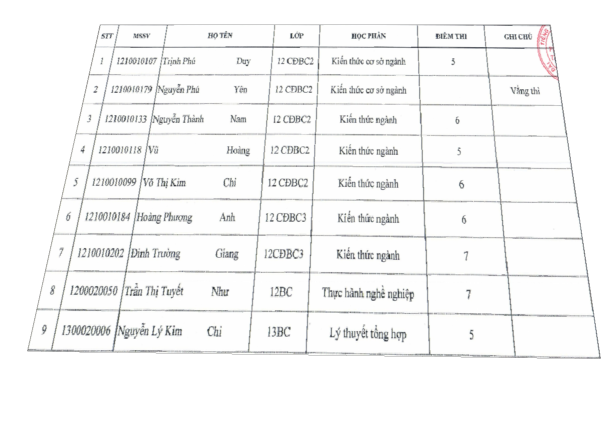

In [90]:
bad_raw = histogramMatching(raw, load("../images/dark.jpg"))
raw